In [1]:
!pip install xgboost

In [65]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV as gs
from sklearn.model_selection import RandomizedSearchCV as rs
import pickle
from sklearn import metrics

In [3]:
url_train='https://raw.githubusercontent.com/dsrscientist/bigdatamart_rep/master/bigdatamart_Train.csv'
url_test='https://raw.githubusercontent.com/dsrscientist/bigdatamart_rep/master/bigdatamart_Test.csv'

In [4]:
train_dataset=pd.read_csv(url_train)
test_dataset=pd.read_csv(url_test)

In [5]:
print('Shape of train : ',train_dataset.shape,'\n\nShape of test : ',test_dataset.shape)

Shape of train :  (8523, 12) 

Shape of test :  (5681, 11)


test dataset doesn't contain same number of columns as train (the missing column is target column)

In [6]:
train_dataset.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [7]:
test_dataset.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


# # Exploratory Data Analysis

In [8]:
# Column Names
for i in train_dataset.columns:
    print(i,'\n')

Item_Identifier 

Item_Weight 

Item_Fat_Content 

Item_Visibility 

Item_Type 

Item_MRP 

Outlet_Identifier 

Outlet_Establishment_Year 

Outlet_Size 

Outlet_Location_Type 

Outlet_Type 

Item_Outlet_Sales 



As we can see there are 12 columns in our train_dataset and Item_Outlet_Sales is the target column rest all are Features 

Description of Each Feature:
1.  Item_Identifier : unique id of the product
2.  Item_Weight : weight of the product
3.  Item_Fat_Content : tells us how fat is contained in the product
4.  Item_Visibility : percentage of area allocated for the product in the store
5.  Item_Type: tells us the category of the item 
6.  Item_MRP: max. retail price of the product
7.  Outlet_Identifier : ID of the store where the product is
8.  Outlet_Establishment_Year : the year in which the store was established 
9.  Outlet_size: Area of the store
10. Outlet_Location_Type: type of city where the store is located
11. Outlet_type: is the store grocery or a supermarket
12. Item_Outlet_Sales: Sales of the item in that particular Store

**Hypothesis: Try to assume the factors which can effect the Data prediction before Analysis

1. Item visiblity can effect the sales as it draws attention of the customers
2. Item type can be most of the affect the sales as depending on the item for example if the item is daily use or consumble raw food item such as milk the sales will be automatically high
3. Year of Establishment because the older the store the more awareness amongst locals about the store 
4. Area of the Store can be the holding platform more customers
5. Location of the store is important because urban population are more attracted to stores commonly

In [9]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Item weight, Item Visibility, Item MRP, Item Oultet Sales are Numerical Data rest all are Categorical Data(Ordinal).
Note: Establishment Year is categorical even after being integer type because the year mentioned is like an ID 

In [10]:
train_dataset.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Noticed:
1. Item weight mean is 12 kilo and max. weight is upto 21kilo
2. The max. price is 266 rupees so safe to assume that no eletronics or gadgets are being sold in any store
3. Establishment year are between 1985-2009

In [11]:
# checking for null values in both train and test datasets
train_dataset.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [12]:
test_dataset.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [13]:
print('Percentage of data missing in train data set \n 1. item weight :',(train_dataset['Item_Weight'].isnull().sum())*100/len(train_dataset['Item_Identifier']),'\n 2. Outlet Size : ',(train_dataset['Outlet_Size'].isnull().sum())*100/len(train_dataset['Item_Identifier']))

Percentage of data missing in train data set 
 1. item weight : 17.165317376510618 
 2. Outlet Size :  28.27642848762173


In [14]:
print('Percentage of data missing in test data set \n 1. item weight :',(test_dataset['Item_Weight'].isnull().sum())*100/len(test_dataset['Item_Identifier']),'\n 2. Outlet Size : ',(test_dataset['Outlet_Size'].isnull().sum())*100/len(test_dataset['Item_Identifier']))

Percentage of data missing in test data set 
 1. item weight : 17.180073930646014 
 2. Outlet Size :  28.269670832599893


Missing values can't be removed as percentage is too high in both data so have to implement some technique

In [15]:
# checking unique data in the dataset
train_dataset.apply(lambda x: len(x.unique()))

Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [16]:
#Filter categorical variables and fetch the numerical values of each ordinal data
ordinal_columns = [x for x in train_dataset.dtypes.index if train_dataset.dtypes[x]=='object']
#Exclude ID cols and source:
ordinal_columns = [x for x in ordinal_columns if x not in ['Item_Identifier','Outlet_Identifier']]
#Print frequency of categories
for col in ordinal_columns:
    print ('\nFrequency of Categories for varible ',col)
    print (train_dataset[col].value_counts())


Frequency of Categories for varible  Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible  Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Frequency of Categories for varible  Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Frequency of Categories for varible  Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int6

In [17]:
# handling missing values of item weight in both the datasets
train_dataset['Item_Weight'].fillna(train_dataset['Item_Weight'].mean(), inplace=True)
test_dataset['Item_Weight'].fillna(test_dataset['Item_Weight'].mean(), inplace=True)

In [18]:
#Determing the mode for train dataset
# filling the missing values in "Outlet_Size" column with Mode
mode_of_outlet_size = train_dataset.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
print ('Mode for each Outlet_Type: ',mode_of_outlet_size)


Mode for each Outlet_Type:  Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


As we can see mode for outlet size varies with the outlet type

In [19]:
#replacing null values with mode
miss_bool_train = train_dataset['Outlet_Size'].isnull() 

train_dataset.loc[miss_bool_train,'Outlet_Size'] = train_dataset.loc[miss_bool_train,'Outlet_Type'].apply(lambda x: mode_of_outlet_size[x])

In [20]:
#checking to see if there anymore null values
train_dataset.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [21]:
#Determing the mode for each for test dataset
# filling the missing values in "Outlet_Size" column with Mode
mode_of_outlet_size_p = test_dataset.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
print ('Mode for each Outlet_Type: ',mode_of_outlet_size_p)

Mode for each Outlet_Type:  Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [22]:
#replacing null values with mode
miss_bool_test = test_dataset['Outlet_Size'].isnull() 

test_dataset.loc[miss_bool_test,'Outlet_Size'] = test_dataset.loc[miss_bool_test,'Outlet_Type'].apply(lambda x: mode_of_outlet_size_p[x])

In [23]:
test_dataset.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

cleared all null values

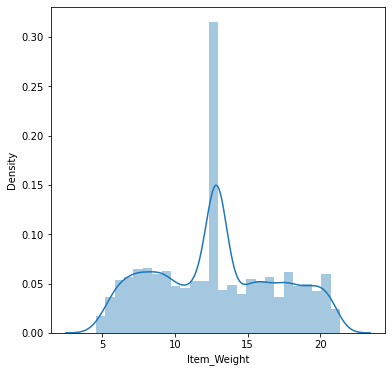

In [24]:
#item weight
plt.figure(figsize=(6,6))
sns.distplot(train_dataset['Item_Weight'])
plt.show()

<AxesSubplot:xlabel='Item_Fat_Content', ylabel='count'>

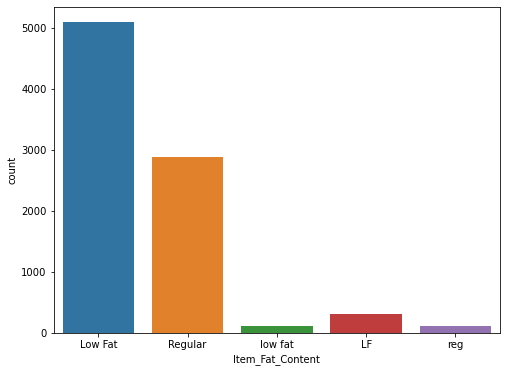

In [25]:
plt.figure(figsize = (8,6))
sns.countplot(x='Item_Fat_Content' ,data=train_dataset)

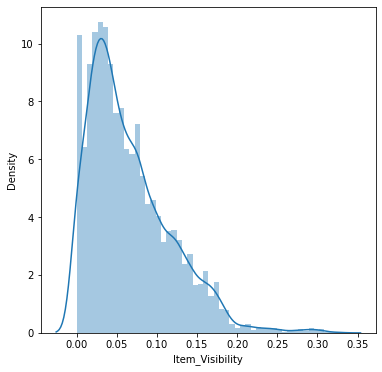

In [26]:
#visibility
plt.figure(figsize=(6,6))
sns.distplot(train_dataset['Item_Visibility'])
plt.show()

<AxesSubplot:xlabel='count', ylabel='Item_Type'>

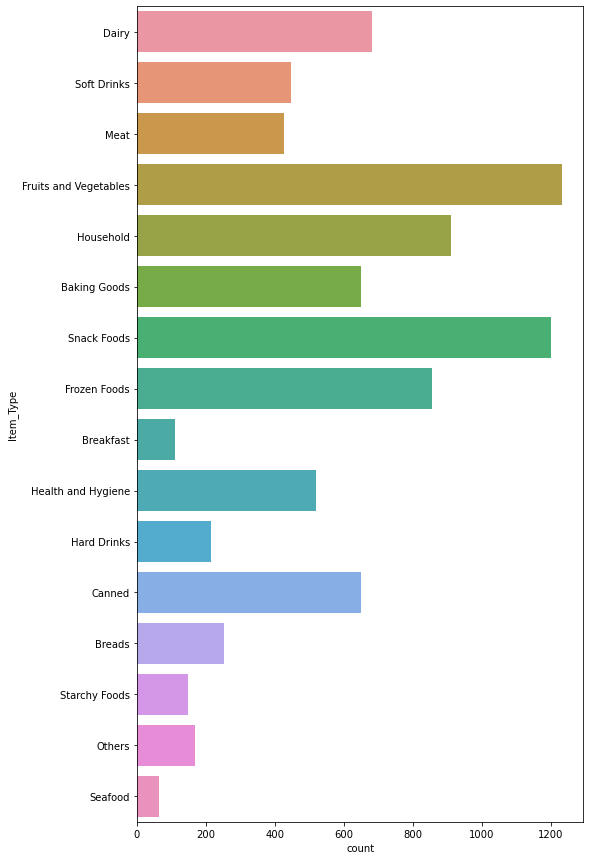

In [27]:
#item type
plt.figure(figsize = (8,15))
sns.countplot(y='Item_Type' ,data=train_dataset)

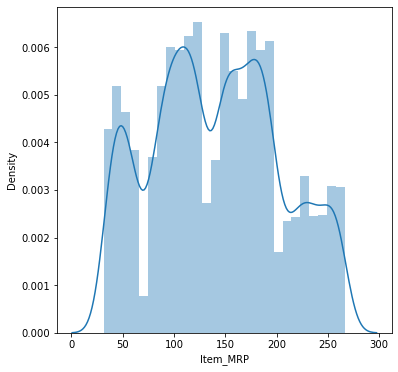

In [28]:
#price
plt.figure(figsize=(6,6))
sns.distplot(train_dataset['Item_MRP'])
plt.show()

<AxesSubplot:xlabel='count', ylabel='Outlet_Identifier'>

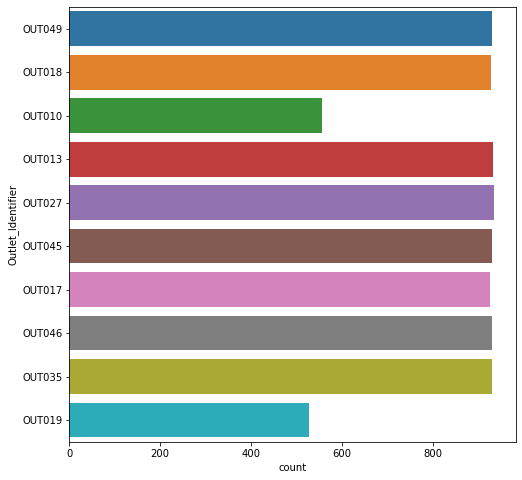

In [29]:
#outlet index
plt.figure(figsize = (8,8))
sns.countplot(y='Outlet_Identifier' ,data=train_dataset)

<AxesSubplot:xlabel='Outlet_Establishment_Year', ylabel='count'>

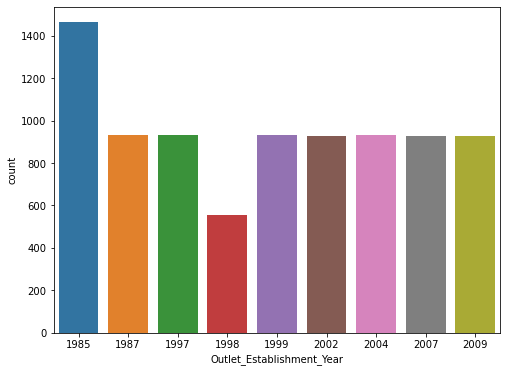

In [30]:
plt.figure(figsize = (8,6))
sns.countplot(x='Outlet_Establishment_Year' ,data=train_dataset)

<AxesSubplot:xlabel='Outlet_Size', ylabel='count'>

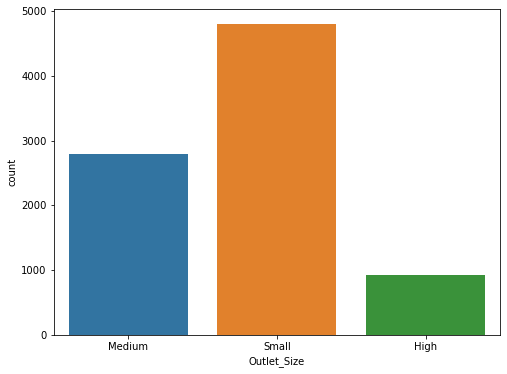

In [31]:
plt.figure(figsize = (8,6))
sns.countplot(x='Outlet_Size' ,data=train_dataset)

<AxesSubplot:xlabel='Outlet_Location_Type', ylabel='count'>

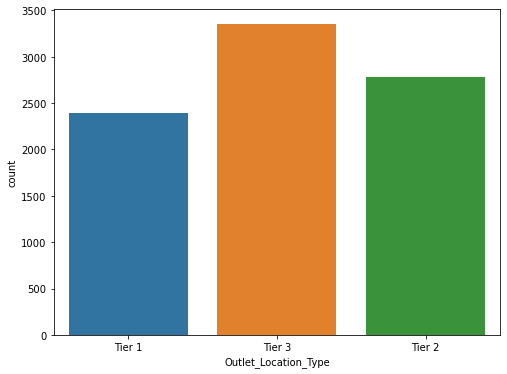

In [32]:
plt.figure(figsize = (8,6))
sns.countplot(x='Outlet_Location_Type' ,data=train_dataset)

<AxesSubplot:xlabel='Outlet_Type', ylabel='count'>

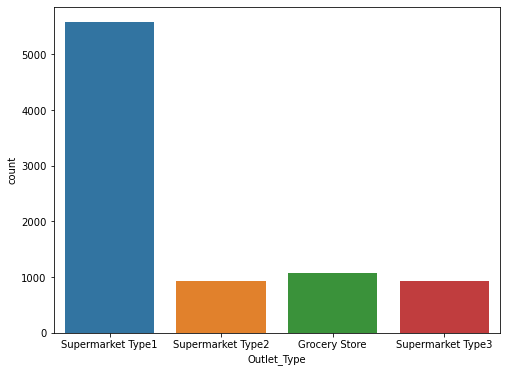

In [33]:
plt.figure(figsize = (8,6))
sns.countplot(x='Outlet_Type' ,data=train_dataset)

In [34]:
print('Skewness of Item weight : ',skew(train_dataset['Item_Weight']))
print('Skewness of Item visibility : ',skew(train_dataset['Item_Visibility']))
print('Skewness of Item MRP : ',skew(train_dataset['Item_MRP']))

Skewness of Item weight :  0.09054551283289146
Skewness of Item visibility :  1.16688513828559
Skewness of Item MRP :  0.1271798803336854


the skewness of item weight and MRP are mininum which can be neglected

        ITEM VISIBILITY


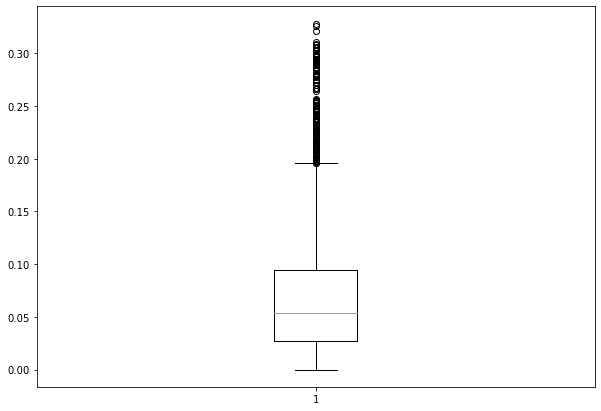

In [35]:
print("        ITEM VISIBILITY")
#Checking outlier in Visibility 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(train_dataset['Item_Visibility'])
 
# show plot
plt.show()

      ITEM MRP


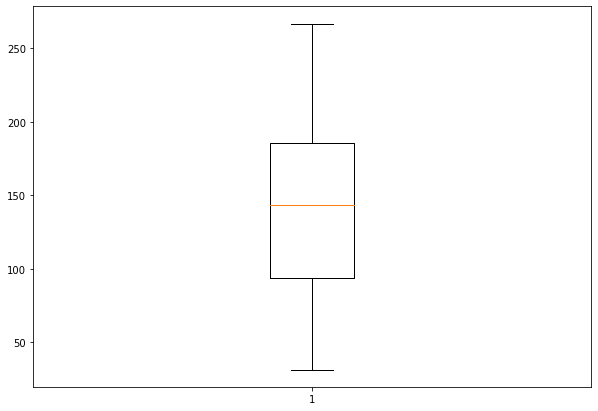

In [36]:
print("      ITEM MRP")
#Checking outlier in Item MRP 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(train_dataset['Item_MRP'])
 
# show plot
plt.show()

       ITEM WEIGHT


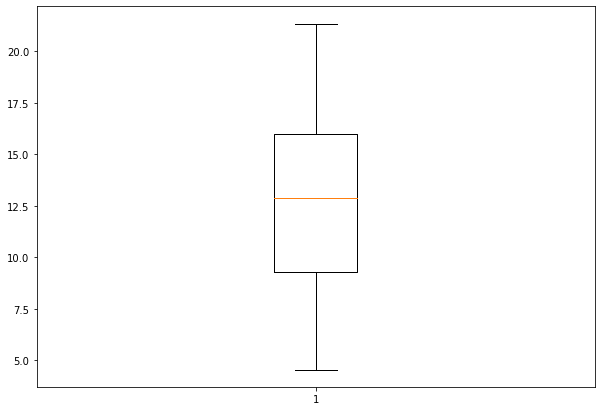

In [37]:
print("       ITEM WEIGHT")
#Checking outlier in item weight
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(train_dataset['Item_Weight'])
 
# show plot
plt.show()

**Summary:
1. Count of Low Fat is more compared to regular and low is also mentioned as LF and low fat which are the same as Low Fat
2. VegetableFruits , Snacks and household have maximum sales compared to other item types , seafood has the least sales
3. store ID: OUT010 AND OUT019 are equal and less count compared to other store ID's which also equal to one another
4. 1985 has highest establishment of all the other year and 1999 has the least establishment , inbetween year 1987-1997 there no establishment ( for a whole decade)
5. Small outlet size have the highest count of all followed by medium and high respectively
6. Tier 3 has the highest count for location type
7. Supermarket1 has the highest count in Outlet type , grocery is marginally greater than Supermarket2,3.
8. skewness in Item MRP and weight are min and can be neglected also no outlier
9. Visibility has positive skewness and outliers can't mend with it until we can see how is its correlation with sales

In [38]:
#modifying the fat content data
train_dataset.replace({'Item_Fat_Content':{'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'}}, inplace=True)
test_dataset.replace({'Item_Fat_Content':{'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'}}, inplace=True)

In [39]:
print('Train data :\n',train_dataset['Item_Fat_Content'].value_counts(),'\n Test data :\n',test_dataset['Item_Fat_Content'].value_counts())

Train data :
 Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64 
 Test data :
 Low Fat    3668
Regular    2013
Name: Item_Fat_Content, dtype: int64


In [40]:
#converting the categorical values into numerical values for train dataset
le= LabelEncoder()
train_dataset['Item_Identifier']=le.fit_transform(train_dataset['Item_Identifier'])
train_dataset['Item_Fat_Content']=le.fit_transform(train_dataset['Item_Fat_Content'])
train_dataset['Item_Identifier']=le.fit_transform(train_dataset['Item_Identifier'])
train_dataset['Item_Type']=le.fit_transform(train_dataset['Item_Type'])
train_dataset['Outlet_Identifier']=le.fit_transform(train_dataset['Outlet_Identifier'])
train_dataset['Outlet_Size']=le.fit_transform(train_dataset['Outlet_Size'])
train_dataset['Outlet_Location_Type']=le.fit_transform(train_dataset['Outlet_Location_Type'])
train_dataset['Outlet_Type']=le.fit_transform(train_dataset['Outlet_Type'])

In [41]:
#converting the categorical values into numerical values for train dataset
test_dataset['Item_Identifier']=le.fit_transform(test_dataset['Item_Identifier'])
test_dataset['Item_Fat_Content']=le.fit_transform(test_dataset['Item_Fat_Content'])
test_dataset['Item_Identifier']=le.fit_transform(test_dataset['Item_Identifier'])
test_dataset['Item_Type']=le.fit_transform(test_dataset['Item_Type'])
test_dataset['Outlet_Identifier']=le.fit_transform(test_dataset['Outlet_Identifier'])
test_dataset['Outlet_Size']=le.fit_transform(test_dataset['Outlet_Size'])
test_dataset['Outlet_Location_Type']=le.fit_transform(test_dataset['Outlet_Location_Type'])
test_dataset['Outlet_Type']=le.fit_transform(test_dataset['Outlet_Type'])

In [42]:
print('Train Data Set Type :\n\n',train_dataset.dtypes,'\n\n\nTest Data Set Type :\n\n',test_dataset.dtypes)

Train Data Set Type :

 Item_Identifier                int64
Item_Weight                  float64
Item_Fat_Content               int32
Item_Visibility              float64
Item_Type                      int32
Item_MRP                     float64
Outlet_Identifier              int32
Outlet_Establishment_Year      int64
Outlet_Size                    int32
Outlet_Location_Type           int32
Outlet_Type                    int32
Item_Outlet_Sales            float64
dtype: object 


Test Data Set Type :

 Item_Identifier                int64
Item_Weight                  float64
Item_Fat_Content               int32
Item_Visibility              float64
Item_Type                      int32
Item_MRP                     float64
Outlet_Identifier              int32
Outlet_Establishment_Year      int64
Outlet_Size                    int32
Outlet_Location_Type           int32
Outlet_Type                    int32
dtype: object


All the Data is converted into numerical data

In [43]:
train_dataset.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


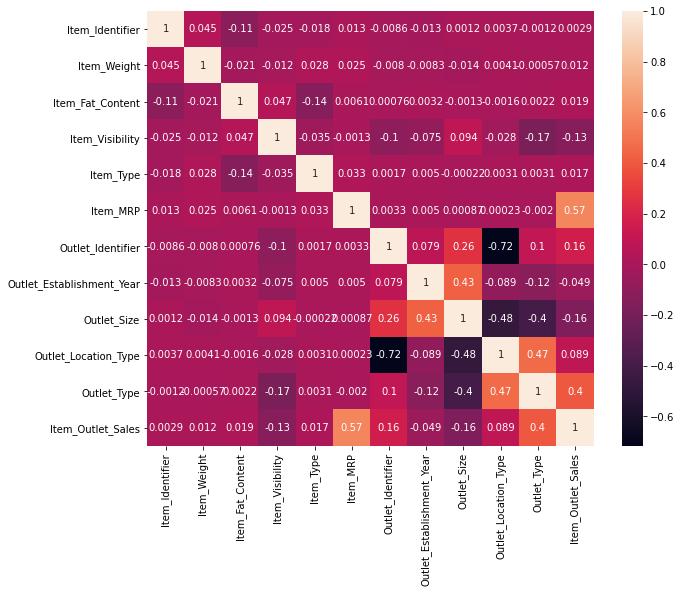

In [44]:
plt.figure(figsize=(10,8))
sns.heatmap(train_dataset.corr(), annot=True)
plt.show()

Visibility has less correlation with the sales lets take a look into the outliers 

In [45]:
missing_values = (train_dataset['Item_Visibility'] == 0)

print ('Number of 0 values in item visibility: %d'%sum(missing_values))

Number of 0 values in item visibility: 526


Zero visibility percentage of area makes no sense where the item is getting sold , so modification the data is necessary

In [46]:
# imputing mean value for zero in train data set
Vmean=train_dataset['Item_Visibility'].mean()
train_dataset.loc[missing_values,'Item_Visibility'] = train_dataset.loc[missing_values,'Item_Identifier'].replace(Vmean)

In [47]:
# imputing mean value for zero in train data set
missing_values_p = (test_dataset['Item_Visibility'] == 0)
Vmean_p=test_dataset['Item_Visibility'].mean()
test_dataset.loc[missing_values_p,'Item_Visibility'] = test_dataset.loc[missing_values_p,'Item_Identifier'].replace(Vmean_p)

# Model Training and prediction

In [48]:
X = train_dataset.drop(columns='Item_Outlet_Sales', axis=1)
Y = train_dataset['Item_Outlet_Sales']

In [66]:
dtc=DecisionTreeRegressor()
paras_dtc={
            'criterion': ['mse','friedman_mse','mae','poisson'],
            'splitter':['best','random'],
            'max_depth': [2,4,6,7,9,10],
            'min_samples_split': [2, 5, 6],
            'min_samples_leaf': [1,2],
            'max_features': ['auto', 'sqrt','log2'],
}
dtc_rs=rs(dtc,param_distributions=paras_dtc,cv=5, verbose=True)
dtc_rs.fit(X,Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(),
                   param_distributions={'criterion': ['mse', 'friedman_mse',
                                                      'mae', 'poisson'],
                                        'max_depth': [2, 4, 6, 7, 9, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5, 6],
                                        'splitter': ['best', 'random']},
                   verbose=True)

In [67]:
dtc_rs.best_estimator_

DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,
                      max_features='auto', min_samples_leaf=2,
                      min_samples_split=5)

In [68]:
model1=DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,
                      max_features='auto', min_samples_leaf=2,
                      min_samples_split=5)
model1.fit(X,Y)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,
                      max_features='auto', min_samples_leaf=2,
                      min_samples_split=5)

In [69]:
training_data_p1=model1.predict(X)
r2_value1=metrics.r2_score(Y,training_data_p1)

In [70]:
print('R Squared value Decision Tree Regression : ', r2_value1)
print('RMSE value for  Decision Tree Regression : ',np.sqrt(metrics.mean_squared_error(Y, training_data_p1)))

R Squared value Decision Tree Regression :  0.677073536465999
RMSE value for  Decision Tree Regression :  969.6891445103186


In [51]:
rfr= RandomForestRegressor()
parameter_rfr={
         'n_estimators': [10, 17, 33, 48, 80],
         'max_features': ['auto', 'sqrt'],
         'max_depth': [2,4,6],
         'min_samples_split': [2, 5, 10],
         'min_samples_leaf': [1, 2],
         'bootstrap': [True, False]
         
}
rfr_gs= gs(estimator =rfr, param_grid=parameter_rfr,cv=3, verbose=2, n_jobs=4)
rfr_gs.fit(X,Y)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4, 6],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 17, 33, 48, 80]},
             verbose=2)

In [52]:
rfr_gs.best_params_

{'bootstrap': True,
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 80}

In [56]:
model2=RandomForestRegressor(bootstrap= True,
 max_depth= 6,
 max_features= 'auto',
 min_samples_leaf= 2,
 min_samples_split= 10,
 n_estimators= 80)

In [58]:
model2.fit(X,Y)

RandomForestRegressor(max_depth=6, min_samples_leaf=2, min_samples_split=10,
                      n_estimators=80)

In [59]:
training_data_p=model2.predict(X)
r2_value=metrics.r2_score(Y,training_data_p)

In [60]:
print('R Squared value for Random forest Regressor ', r2_value)
print('RMSE value for Random forest Regressor: ',np.sqrt(metrics.mean_squared_error(Y, training_data_p)))

R Squared value for Random forest Regressor  0.6206462051835795
RMSE value for Random forest Regressor:  1051.0005225275595


In [106]:
xgb=XGBRegressor
param_grid = {
    'n_estimators': [20, 200],
    'max_depth': [3, 4, 5, 6, 8, 15],
    'learning_rate':[0.1,0.15,0.2,0.3],
    'gamma':[0.0,0.1,0.2,0.3],
    'n_jobs':[100,200,300]
}
CV_xgb = RandomizedSearchCV(xgb,param_distributions=param_grid,scoring ='roc_auc',cv=5,verbose=5)
CV_xgb.fit(X,Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END gamma=0.1, learning_rate=0.15, max_depth=3, n_estimators=20, n_jobs=300; total time=   0.0s
[CV 2/5] END gamma=0.1, learning_rate=0.15, max_depth=3, n_estimators=20, n_jobs=300; total time=   0.0s
[CV 3/5] END gamma=0.1, learning_rate=0.15, max_depth=3, n_estimators=20, n_jobs=300; total time=   0.0s
[CV 4/5] END gamma=0.1, learning_rate=0.15, max_depth=3, n_estimators=20, n_jobs=300; total time=   0.0s
[CV 5/5] END gamma=0.1, learning_rate=0.15, max_depth=3, n_estimators=20, n_jobs=300; total time=   0.0s
[CV 1/5] END gamma=0.3, learning_rate=0.2, max_depth=8, n_estimators=20, n_jobs=300; total time=   0.1s
[CV 2/5] END gamma=0.3, learning_rate=0.2, max_depth=8, n_estimators=20, n_jobs=300; total time=   0.1s
[CV 3/5] END gamma=0.3, learning_rate=0.2, max_depth=8, n_estimators=20, n_jobs=300; total time=   0.2s
[CV 4/5] END gamma=0.3, learning_rate=0.2, max_depth=8, n_estimators=20, n_jobs=300; total time=   0.1

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          enable_categorical=False, gamma=0,
                                          gpu_id=-1, importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=20, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=20, n...
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=0, reg_alph

In [112]:
CV_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=300,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [114]:
model3=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             learning_rate=0.15, max_delta_step=0,
             max_depth=3, min_child_weight=1,
             monotone_constraints='()', n_estimators=20, n_jobs=300,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [116]:
model3.fit(X,Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=300,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [117]:
training_data_p_for_xgb=model3.predict(X)
r2_value_xgb=metrics.r2_score(Y,training_data_p_for_xgb)

In [118]:
print('R Squared value for XGB Regressor : ', r2_value_xgb)
print('RMSE value for XGB Regressor : ',np.sqrt(metrics.mean_squared_error(Y, training_data_p_for_xgb)))

R Squared value for XGB Regressor :  0.6030918306119886
RMSE value for XGB Regressor :  1075.04274947997


Of all the model Decision Tree Regressor has higher accuracy and RMSE value compared to XGBRegressor and Random Forest Regressor

# Predicting test Data

In [72]:
predicted_sales_values=model1.predict(test_dataset)

In [76]:
framed_prediction_dtr=pd.DataFrame(predicted_sales_values)
framed_prediction_dtr.head()

,0
0,1684.390238
1,1273.302764
2,706.234546
3,2237.401728
4,6348.421755


In [77]:
#saving the model
Decision_Tree_R_Model_for_BigMart= pickle.dumps(model1)